<a href="https://colab.research.google.com/github/TairCohen/personal-nutritionist-agent/blob/tair/basic_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [120]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
import graph_nodes
graph_nodes.get_image_path
graph_nodes.display_image

<function graph_nodes.display_image(state: graph_nodes.State)>

In [ ]:
try:
  import google.colab
  IN_COLAB = True
  !pip install -q langgraph
  !pip install -q --upgrade langchain-text-splitters langchain-community langgraph
  !pip install -q langchain-openai
  !pip install faiss-cpu>=1.7.4
  !pip install -q langchain
except:
  IN_COLAB = False

In [131]:
# in jupyter, run this cell to reload the graph_nodes module
# if you make changes to it
# and want to test them without restarting the kernel
import importlib
import graph_nodes
importlib.reload(graph_nodes)

<module 'graph_nodes' from '/Users/tairlax/Desktop/30_hours/personal-nutritionist-agent/graph_nodes.py'>

In [132]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from graph_nodes import State, assistant, upload_image, display_image, identify_food, get_calories
from graph_nodes import tools , tools_condition
# from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage #, SystemMessage


# Define a new graph
workflow = StateGraph(State)
workflow.add_node("assistant", assistant)
workflow.add_node("get_image_path", ToolNode(tools))
# workflow.add_node("upload_image", ToolNode(tools))
workflow.add_node("display_image", display_image)
workflow.add_node("identify_food", identify_food)
workflow.add_node("get_calories", get_calories)


# Set the entrypoint as conversation
workflow.add_edge(START, "assistant")
# workflow.add_edge("assistant", "upload_image")
workflow.add_conditional_edges(
    "assistant",
    tools_condition,
    path_map={
        "get_image_path": "get_image_path",
        "__else__": END,  # fallback if no tool call matches
    }
)
# workflow.add_edge("get_image_path", "assistant")
# workflow.add_edge("upload_image", "display_image")

workflow.add_edge("get_image_path", "display_image")
workflow.add_edge("display_image", "identify_food")
workflow.add_edge("identify_food", "get_calories")
workflow.add_edge("get_calories", "assistant")


# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory) #interrupt_before=["display_image"], 

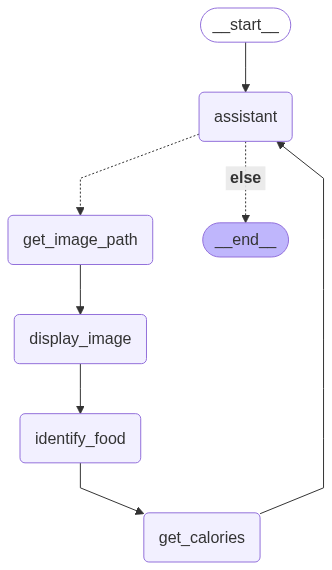

In [99]:
display(Image(graph.get_graph().draw_mermaid_png()))
# display(Image(graph.get_graph().draw_mermaid_png(max_retries=5, retry_delay=2.0)))
# print(graph.get_graph().draw_mermaid())  # This gives raw Mermaid code
# paste the result here: https://www.mermaidchart.com/app/projects/dae41c67-391d-4652-ad73-51aab98d3183/diagrams/aa29f817-462e-43e9-aa09-335676caadda/version/v0.1/edit

tool details [{'name': 'get_image_path', 'args': {}, 'id': 'call_LGckctcikXLUBW61aj9WHNdp', 'type': 'tool_call'}]
ddd
ff {'messages': [HumanMessage(content='get image path', additional_kwargs={}, response_metadata={}, id='e3067c47-ef5a-460a-b6c1-a2613bc17673'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_LGckctcikXLUBW61aj9WHNdp', 'function': {'arguments': '{}', 'name': 'get_image_path'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 67, 'total_tokens': 78, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_de235176ee', 'id': 'chatcmpl-BZikOBKdaEFmpLfvdZlUuD6yLDZOK', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--84c5b798-3c8d-4aa0-b021

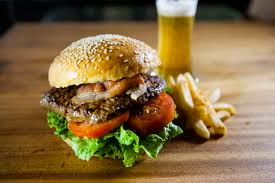

================================== Ai Message ==================================

The dish in the picture appears to be a classic burger with fries. Here's the list of ingredients typically making up the dish, along with estimated weights for each in grams:

1. Burger bun - 70g
2. Beef patty - 120g
3. Lettuce - 20g
4. Tomato slice - 30g
5. Bacon strips - 20g
6. Cheese slice - 20g
7. French fries (side portion) - 100g

These weights are approximate, as actual amounts can vary depending on the specific recipe and restaurant serving size.
None
To estimate the total calories in a classic burger with fries as described, we'll calculate the calorie content for each ingredient and then sum them up. Here's a detailed breakdown:

1. **Burger Bun (70g)**
   - Calories for burger bun can vary widely, but a typical white burger bun has about 250 calories per 100g. That would make it approximately:
   - \( \text{Calories} = 250 \times (70/100) = 175 \text{ calories} \)

2. **Beef Patty (120g)**
   

In [133]:
config = {"configurable": {"thread_id": "1"}}
mass = "Add 3 and 4. Multiply the output by 2. Divide the output by 5"
mass = "get image path"
# mass = "thank you"
messages = [HumanMessage(content=mass)]
output = graph.invoke({"messages": messages}, config)

for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================

I'm 50 years old, what should I eat?
================================== Ai Message ==================================

As a 50-year-old, it's important to focus on a balanced diet that promotes health and well-being, while also considering any specific health conditions or nutritional needs you might have. A well-balanced diet can help manage weight, maintain muscle mass, and reduce the risk of chronic diseases such as heart disease, diabetes, and osteoporosis.

Here are some general dietary guidelines to consider:

1. **Fruits and Vegetables:** Aim for at least 5 servings per day. These provide essential vitamins, minerals, and fiber that help maintain body functions and support the immune system.

2. **Lean Proteins:** Include lean meats, poultry, fish, beans, and legumes in your diet to help maintain and build muscle mass. Fish such as salmon and mackerel are good sources of omega-3 fatty acids, which 

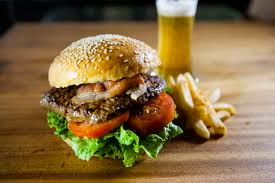

================================== Ai Message ==================================

From the image provided, the dish appears to be a burger with fries. Here's an estimated list of the ingredients used in the burger, along with their typical weights:

1. Hamburger bun (top and bottom): 80 grams
2. Beef patty: 120 grams
3. Slice of bacon: 15 grams
4. Lettuce leaf: 5 grams
5. Slices of tomato: 20 grams
6. French fries (serving): 150 grams

These weights are approximate and can vary depending on the restaurant or recipe specifics.
None
To calculate the total calorie estimate for the described burger with fries, we need to look at each component separately. We don't have an exact match in our database for a burger with all these specific components, so we'll compute the calories based on individual ingredients and summed up totals:

1. **Hamburger Bun:**
   - The typical hamburger bun is around 250 calories for 100 grams. At 80 grams, this would equate to about 200 calories.

2. **Beef Patty

In [134]:

config = {"configurable": {"thread_id": "2"}}
while True:
    text = input("You: ")
    if text.lower() == "exit":
        break
    messages = [HumanMessage(content=text)]
    messages[-1].pretty_print()
    output = graph.invoke({"messages": messages}, config) # after tool the it not goes to end, so i cannot do invke again, maybe stream
    output['messages'][-1].pretty_print()
